In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from bokeh.layouts import gridplot
from bokeh.models import Range1d
from bokeh.plotting import figure, show

In [2]:
def SIRSelke(n,m,Q,I,lmb):
    """Function that runs a Sellke construction of a simple SIR model with a constant infectivity
    n - number of initial susceptibles
    m - number of initial infectives
    Q - n length vector with the individual thresholds of each of the susceptibles
    I - n+m length vector of the infectious periods of each of the individuals in the simulation"""
    A = 0 
    t = 0
    
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    active_tau = [np.inf]*(n+m)
    
    for k in infected_indices:
        active_tau[k] = I[k]
    

    
    next_recovery_tau = min(active_tau)
    next_recovery_i = active_tau.index(next_recovery_tau)
    
    next_infection_i = m

    while len(infected_indices)>0:
        #Decide whether next event is a recovery or an infection
        A_check = A + (lmb/n)*next_recovery_tau*len(infected_indices)
        
        
        
        if A_check<Q[next_infection_i-m]:
            #print("Recovery")
            #Next event is recovery  
            A += (lmb/n)*next_recovery_tau*len(infected_indices)
            
            t+= next_recovery_tau
            t_recov[next_recovery_i] = t
            active_tau = [tau-next_recovery_tau for tau in active_tau]
            active_tau = [np.inf if tau ==0 else tau for tau in active_tau]
                    
            
            recovered_indices.append(next_recovery_i)
            infected_indices.remove(next_recovery_i)
            
            next_recovery_tau = min(active_tau)
            next_recovery_i = active_tau.index(next_recovery_tau)
            
        else:
            #Next event is an infection
            tau_of_inf = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
            A+= (lmb/n)*tau_of_inf*len(infected_indices)
            
            t+=tau_of_inf
            
            t_inf[next_infection_i] = t
            active_tau = [tau-tau_of_inf for tau in active_tau]
            active_tau[next_infection_i] = I[next_infection_i]
            
            next_recovery_tau = min(active_tau)
            next_recovery_i = active_tau.index(next_recovery_tau)
            
            infected_indices.append(next_infection_i)
            susceptible_indices.remove(next_infection_i)
            
            next_infection_i += 1
            
            if next_infection_i>=50:
                for i in infected_indices:
                    t_recov[i] = t+active_tau[i]
                    
                break
            

    return(recovered_indices)
            

In [337]:
def SIRSelke_pulse(n,m,Q,I,lmb,T,P,p):
    """Function that runs a Sellke construction of a simple SIR model with a constant infectivity. Includes a constant testing rate
    n - number of initial susceptibles
    m - number of initial infectives
    Q - n length vector with the individual thresholds of each of the susceptibles
    I - n+m length vector of the infectious periods of each of the individuals in the simulation"""
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    
    pulsed = False
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    active_tau = [np.inf]*(n+m)
    
    for k in infected_indices:
        active_tau[k] = I[k]
    

    
    next_recovery_tau = min(active_tau)
    next_recovery_i = active_tau.index(next_recovery_tau)
    
    next_infection_i = m
    next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))

    while len(infected_indices)>0:
        #Decide whether next event is a recovery, infection or pulse
        A_check = A + (lmb/n)*next_recovery_tau*len(infected_indices)
        
        
        
        #print(next_recovery_tau)
        #input(active_tau)
        #print()
        
        if ((T-t)<min(next_recovery_tau,next_infection_tau)) and pulsed == False:
            #print("Pulse!")
            #print(infected_indices)
            #Pulse test
            dt = T-t
            A+= (lmb/n)*dt*len(infected_indices)
            t = T
            
            active_tau = [tau-dt for tau in active_tau]
            
            indices_spotted = []
            
           
            for i in infected_indices:
                if P[i]<p:
                    indices_spotted.append(i)
                    
                    active_tau[i] = np.inf
                    
                    
            for i in indices_spotted:
                recovered_indices.append(i)
                infected_indices.remove(i)
                t_recov[i] = t
                
                
            next_recovery_tau = min(active_tau)
            next_recovery_i = active_tau.index(next_recovery_tau)
            
            next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
            
            pulsed = True
            #print(infected_indices)
        
        elif A_check<Q[next_infection_i-m]:
            #print("Recovery")
            #Next event is recovery  
            A += (lmb/n)*next_recovery_tau*len(infected_indices)
            
            t+= next_recovery_tau
            t_recov[next_recovery_i] = t
            active_tau = [tau-next_recovery_tau for tau in active_tau]
            active_tau = [np.inf if tau ==0 else tau for tau in active_tau]
                    
            
            recovered_indices.append(next_recovery_i)
            infected_indices.remove(next_recovery_i)
            
            next_recovery_tau = min(active_tau)
            next_recovery_i = active_tau.index(next_recovery_tau)
            
            next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
            
        
            
        else:
            #print("Infection")
            #Next event is an infection
            next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
            
            
                
            A+= (lmb/n)*next_infection_tau*len(infected_indices)
            
            t+=next_infection_tau
            
            t_inf[next_infection_i] = t
            active_tau = [tau-next_infection_tau for tau in active_tau]
            active_tau[next_infection_i] = I[next_infection_i]
            
            next_recovery_tau = min(active_tau)
            next_recovery_i = active_tau.index(next_recovery_tau)
            
            infected_indices.append(next_infection_i)
            susceptible_indices.remove(next_infection_i)
            
            next_infection_i += 1
            next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
            
            if next_infection_i>=50:
                for i in infected_indices:
                    t_recov[i] = t+active_tau[i]
                    
                break
                
                
                
                
                
                
                
        t_v.append(t)
        A_v.append(A)
        #print("t=",t)
        #print("A =",A) 
        #print(active_tau)
        #print("")


    return(t_v,A_v,t_inf,t_recov,recovered_indices)
            

In [397]:
Q_unsorted = np.random.exponential(1,n)
Q = np.sort(Q_unsorted)
P = np.random.uniform(0,1,n+m)

T= 1    Z= 3    Final t= 1
T= 2    Z= 4    Final t= 2
T= 3    Z= 44    Final t= 8.007046305095697
T= 4    Z= 39    Final t= 6.7730653530092
T= 5    Z= 43    Final t= 7.797788381189992
T= 6    Z= 43    Final t= 6.6221867691332035
T= 7    Z= 44    Final t= 7.4903988651659015
T= 8    Z= 44    Final t= 7.4903988651659015
T= 9    Z= 44    Final t= 7.4903988651659015
T= 10    Z= 44    Final t= 7.4903988651659015
T= 100    Z= 44    Final t= 7.4903988651659015


C:\Users\joebr\AppData\Local\Temp\ipykernel_11852\856489652.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
C:\Users\joebr\AppData\Local\Temp\ipykernel_11852\856489652.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))


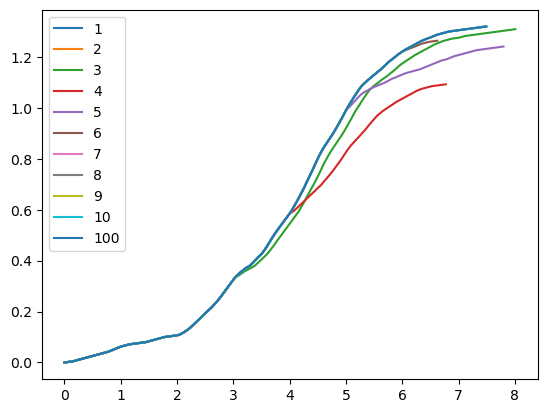

In [ ]:
times = [1,2,3,4,5,6,7,8,9,10,100]
p=0.5

for T in times:
    result = SIRSelke_pulse(n,m,Q,I,lamb,T,P,p)
    plt.plot(result[0],result[1],label = str(T))
    print("T=",T,"   Z=", len(result[4]), "   Final t=",result[0][-1])
plt.legend()


In [272]:
Pn = [0.22313016014842982,0.07812092032156226,0.041851315336848494,0.027046526858429898,0.019516664670509776,0.015179028588497123,0.012480381609877328,0.0107200755796939,0.009543566870151426,0.008756232503306594,0.00824484362089832,0.00794090235588149,0.007802109849281674,0.00780233355634774,0.007926142411960865,0.00816492653175939,0.008515796063325462,0.008978526390125932,0.009556666809744652,0.010254340481022153,0.011077628033144438,0.012030504060036196,0.0131210057295654,0.014340987404124844,0.015705903935287868,0.01717433219559228,0.018774051087102117,0.02041206530124598,0.022117723154696817,0.02374752909751382,0.025302808106481,0.026614168190601695,0.027628233294395177,0.028189711678697493,0.028202781636006535,0.02757347901992907,0.026230748254855718,0.024195172346066662,0.021509382366740354,0.01834233348406908,0.01488707440131759,0.011416065869428893,0.008184708306199315,0.005421732520758719,0.003266153264113607,0.001753437118265113,0.0008156604164100056,0.00031569383558495727,9.532467349553314e-05,1.996496779096263e-05,0]

In [399]:
m = 1
n = 50
I = [1]*n

P = np.random.uniform(0,1,n+m)
p = 0.5
times = [1,2,3,4,5,6,7,8,9,10]#np.linspace(2,10,5)
full_data = []
for i in range(len(times)):
    data=[]
    T = times[i]

    lamb = 1.5
    for i in tqdm(range(100000)):
        Q_unsorted = np.random.exponential(1,n)
        Q = np.sort(Q_unsorted)
        #I = np.random.exponential(1,n+m)
        result = SIRSelke_pulse(n,m,Q,I,lamb,T,P,p)
        data.append(len(result[4]))
    full_data.append(data)

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]C:\Users\joebr\AppData\Local\Temp\ipykernel_11852\856489652.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
C:\Users\joebr\AppData\Local\Temp\ipykernel_11852\856489652.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  next_infection_tau = (Q[next_infection_i-m]-A)/((lmb/n)*len(infected_indices))
100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3078.57it/s]


In [400]:

# Histogram
bins = np.linspace(0, 50, 51)
for i in range(len(times)):
    f = figure(width=670, height=400, toolbar_location=None,
           title="Sellke Construction of SIR model with constant infectivity and infectious period 1")
    hist, edges = np.histogram(full_data[i], density=True, bins=bins)
    f.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
             fill_color="skyblue", line_color="white",
             legend_label="Simulated data")
    f.circle(np.linspace(1.5, 50.5, 50), Pn, size=5, color="red", alpha=1,
             legend_label="Exact Distribution")
    f.x_range = Range1d(0, 50)
    f.y_range = Range1d(0, 0.25)

    show(f)


In [234]:
# Histogram
bins = np.linspace(0, 50, 51)
for i in range(3):
    f = figure(width=670, height=400, toolbar_location=None,
           title="Sellke Construction of SIR model with constant infectivity and infectious period 1")
    hist, edges = np.histogram(full_data[i], density=True, bins=bins)
    f.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
             fill_color="skyblue", line_color="white",
             legend_label="Simulated data")
    f.circle(np.linspace(1.5, 50.5, 50), Pn, size=5, color="red", alpha=1,
             legend_label="Exact Distribution")
    f.x_range = Range1d(0, 5)
    f.y_range = Range1d(0, 0.25)

    show(f)
